In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import seaborn as sns
# stops = set(stopwords.words('english')).union(set(list(punctuation)))
nltk.download('stopwords')
stops = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
original_df = pd.read_csv("complaints.csv")[['Product', 'Consumer complaint narrative']].rename({'Consumer complaint narrative': 'text'}, axis=1)

original_df.head()

<ipython-input-3-728df1cc5791>:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  original_df = pd.read_csv("complaints.csv")[['Product', 'Consumer complaint narrative']].rename({'Consumer complaint narrative': 'text'}, axis=1)


,Product,text
0,"Credit reporting, credit repair services, or o...",NaN
1,"Credit reporting, credit repair services, or o...",NaN
2,"Credit reporting, credit repair services, or o...",NaN
3,"Credit reporting, credit repair services, or o...",NaN
4,"Credit reporting, credit repair services, or o...",NaN


In [ ]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3440170 entries, 0 to 3440169
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   Product  object
 1   text     object
dtypes: object(2)
memory usage: 52.5+ MB


In [ ]:
print('N/A:', len(original_df[original_df['text'].isna()]))
print('Not N/A:', len(original_df[~original_df['text'].isna()]))

N/A: 2199442
Not N/A: 1240728


In [ ]:
original_df = original_df.dropna(axis=0, subset=['text']).reset_index(drop=True)
print(len(original_df))
original_df.head()

1240728


,Product,text
0,"Credit reporting, credit repair services, or o...",In accordance with the Fair Credit Reporting a...
1,"Credit reporting, credit repair services, or o...",This company is still reporting on an account ...
2,"Credit reporting, credit repair services, or o...","ON XX/XX/2022, MY XX/XX/2022 RECORDED CALL FRO..."
3,"Credit reporting, credit repair services, or o...",XXXX/ XXXX credit card balance was incorrectl...
4,"Credit reporting, credit repair services, or o...",My credit report contains a significant number...


In [ ]:
print(original_df.iloc[0]['Product'])
print(original_df.iloc[0]['text'])

Credit reporting, credit repair services, or other personal consumer reports
In accordance with the Fair Credit Reporting act the companies listed below have violated my rights per : 15 U.S.C 1681 section 602 A. States I have the right to privacy.

15 U.S.C 1681 Section 604 A Section 2 : It also states a consumer reporting agency can not furnish a account without my written instructions XXXX XXXX XXXX XXXX  account ending # XXXX XXXX XXXX XXXX XXXX account ending # XXXX XXXX XXXX XXXX XXXX XXXX, account ending # XXXX XXXX XXXX XXXX XXXX XXXX, account ending # XXXX XXXX XXXX, account ending # XXXX XXXX XXXX, account ending # XXXX XXXX XXXXXXXX XXXX account ending # XXXX XXXX XXXX XXXX account ending # XXXX XXXX XXXX XXXX XXXX XXXX, account ending # XXXX XXXX XXXX XXXX XXXX XXXX, account ending # XXXX XXXX XXXX account ending # XXXX XXXX XXXX XXXX XXXX


In [ ]:
original_df.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    604962
Debt collection                                                                 201066
Mortgage                                                                        102113
Credit card or prepaid card                                                      89667
Checking or savings account                                                      62793
Student loan                                                                     34321
Credit reporting                                                                 31587
Money transfer, virtual currency, or money service                               29159
Vehicle loan or lease                                                            22181
Credit card                                                                      18838
Bank account or service                                                          14885
Payday loan, title loan, or personal loan  

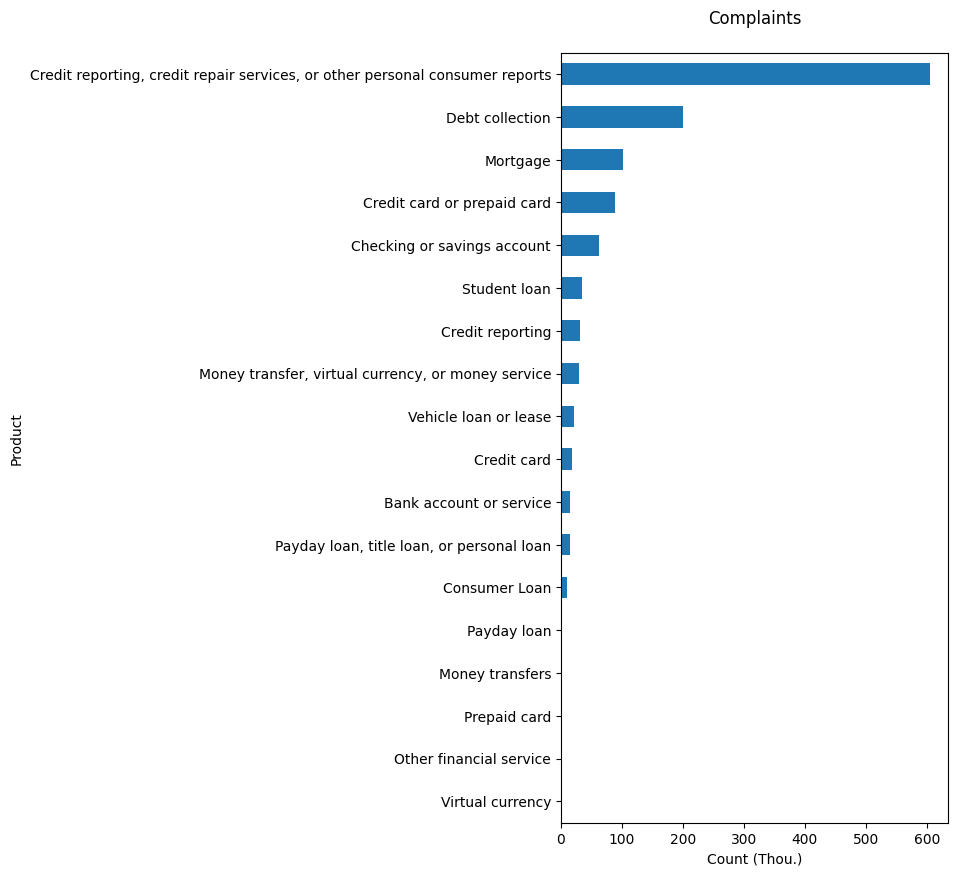

In [ ]:
plt.figure(figsize=(5, 10));
(original_df.groupby('Product').text.count().sort_values()/1000).plot.barh(ylim=0, title='Complaints\n')
plt.xlabel('Count (Thou.)', fontsize = 10);

In [ ]:
# other = original_df[~(original_df.Product == original_df.iloc[0].Product)]
# reporting = original_df[original_df.Product == original_df.iloc[0].Product]
# df = pd.concat([other, reporting.sample(200000)])

dfs = []

for p in original_df.Product.unique():
    tmp = original_df[original_df.Product == p]
    if len(tmp) <= 20000:
        dfs.append(tmp)
    else:
        dfs.append(tmp.sample(20000))
df = pd.concat(dfs).reset_index(drop=True)

In [ ]:
print(df.Product.value_counts())
print('Total:', len(df))

Credit reporting, credit repair services, or other personal consumer reports    20000
Checking or savings account                                                     20000
Debt collection                                                                 20000
Credit card or prepaid card                                                     20000
Mortgage                                                                        20000
Student loan                                                                    20000
Vehicle loan or lease                                                           20000
Money transfer, virtual currency, or money service                              20000
Credit reporting                                                                20000
Credit card                                                                     18838
Bank account or service                                                         14885
Payday loan, title loan, or personal loan             

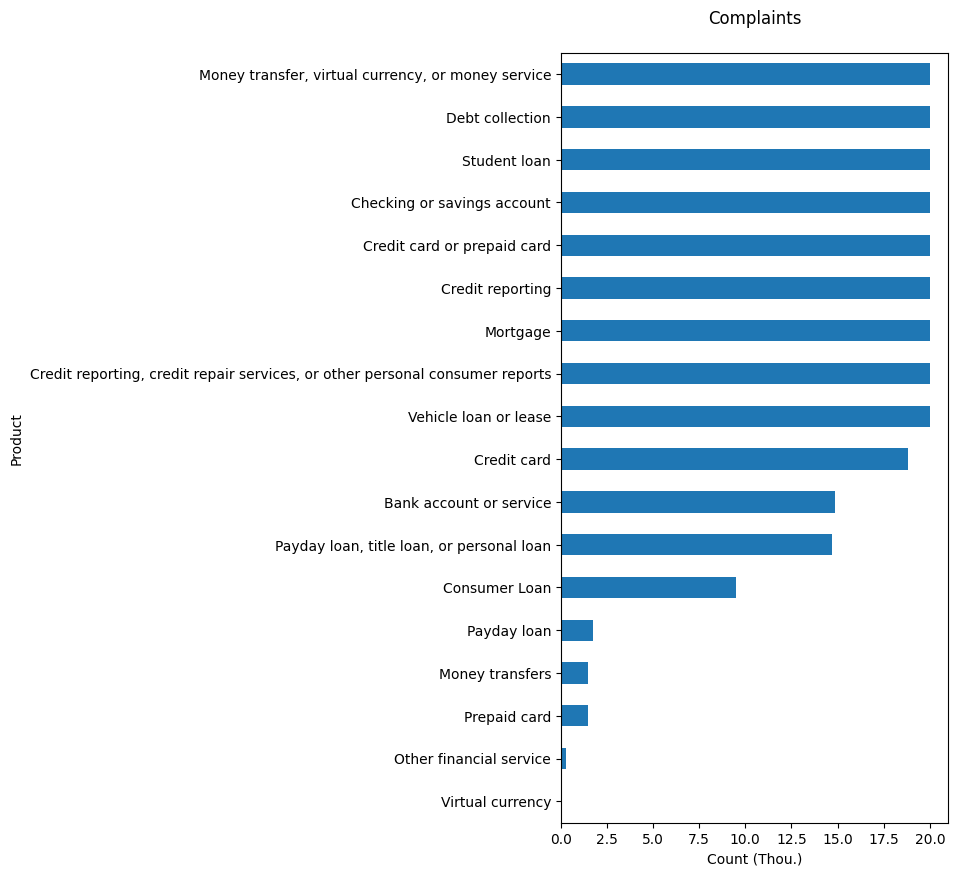

In [ ]:
plt.figure(figsize=(5, 10));
(df.groupby('Product').text.count().sort_values()/1000).plot.barh(ylim=0, title='Complaints\n')
plt.xlabel('Count (Thou.)', fontsize = 10);

In [ ]:
df['text'] = df['text'].str.lower()
df

,Product,text
0,"Credit reporting, credit repair services, or o...",my personal information was mishandled by the ...
1,"Credit reporting, credit repair services, or o...",the company is in violation of multiple far cr...
2,"Credit reporting, credit repair services, or o...",the accounts listed do not belong to me someon...
3,"Credit reporting, credit repair services, or o...","there is inaccurate, misleading, incorrect, ou..."
4,"Credit reporting, credit repair services, or o...",on today. xx/xx/2018 i ordered copies of my cr...
...,...,...
242874,Virtual currency,i received a random notice 3 days ago from a d...
242875,Virtual currency,"hi, i purchased bitcoins from a website coinba..."
242876,Virtual currency,signed up with coinbase.com with a {$75.00} si...
242877,Virtual currency,"i applied for an account on "" circle '' and th..."


In [ ]:
training, testing = train_test_split(df, test_size=0.2)
X_train, y_train, X_test, y_test = training.text, training.Product, testing.text, testing.Product


In [ ]:
tfidf = TfidfVectorizer(max_features=500, stop_words=stops)
features = tfidf.fit_transform(X_train)
test_features = tfidf.transform(X_test)

In [ ]:
features = features.toarray()
test_features = test_features.toarray()

In [ ]:
features_df = pd.DataFrame(features, columns=tfidf.get_feature_names_out())

pd.options.display.float_format = '{:,.2f}'.format
features_df.reindex(features_df.mean().sort_values(ascending=False).index, axis=1)

,xxxx,xx,account,credit,00,loan,bank,payment,card,report,...,consumers,protection,continued,note,clearly,therefore,document,directly,receipt,dated
0,0.10,0.32,0.14,0.00,0.33,0.00,0.19,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.07,0.23,0.00,0.21,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.71,0.20,0.13,0.00,0.00,0.00,0.12,0.12,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.11,0.00,0.00
3,0.00,0.00,0.00,0.16,0.00,0.00,0.00,0.00,0.00,0.22,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.15,0.25,0.16,0.11,0.00,0.00,0.00,0.00,0.00,0.16,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194298,0.52,0.29,0.09,0.00,0.00,0.06,0.00,0.12,0.06,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
194299,0.00,0.00,0.00,0.38,0.00,0.00,0.00,0.00,0.00,0.26,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
194300,0.06,0.00,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
194301,0.38,0.00,0.00,0.37,0.00,0.00,0.00,0.00,0.13,0.13,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
results = pd.DataFrame(columns=['Product'] + list(features_df))
for prod in y_train.unique():
    filt = y_train == prod
    results.loc[len(results.index)] = [prod] + list(features_df.to_numpy()[filt].mean(axis=0))

results.to_csv('tfidf_mean.csv', index=False)
results

,Product,00,10,100,15,2015,2016,2019,2020,2021,...,would,writing,written,wrong,xx,xxxx,xxxxxxxx,year,years,yet
0,Bank account or service,0.07,0.01,0.01,0.01,0.02,0.03,0.00,0.00,0.00,...,0.04,0.00,0.01,0.01,0.05,0.22,0.00,0.01,0.02,0.01
1,Debt collection,0.03,0.00,0.00,0.02,0.00,0.00,0.01,0.01,0.01,...,0.02,0.01,0.01,0.01,0.09,0.23,0.01,0.01,0.02,0.01
2,"Money transfer, virtual currency, or money ser...",0.06,0.01,0.01,0.00,0.00,0.00,0.01,0.01,0.02,...,0.03,0.00,0.00,0.01,0.12,0.25,0.01,0.00,0.01,0.01
3,"Credit reporting, credit repair services, or o...",0.02,0.00,0.00,0.04,0.00,0.00,0.01,0.01,0.01,...,0.01,0.01,0.02,0.01,0.09,0.29,0.02,0.00,0.01,0.01
4,Mortgage,0.05,0.01,0.00,0.01,0.01,0.01,0.01,0.01,0.01,...,0.04,0.01,0.01,0.01,0.14,0.25,0.00,0.02,0.02,0.01
5,Checking or savings account,0.07,0.01,0.01,0.00,0.00,0.00,0.01,0.01,0.01,...,0.04,0.00,0.00,0.01,0.14,0.20,0.01,0.01,0.01,0.01
6,Credit card,0.06,0.01,0.01,0.01,0.02,0.02,0.00,0.00,0.00,...,0.04,0.00,0.00,0.01,0.05,0.20,0.00,0.01,0.02,0.01
7,Student loan,0.05,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00,...,0.04,0.00,0.00,0.01,0.11,0.21,0.00,0.02,0.04,0.01
8,Credit reporting,0.01,0.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00,...,0.02,0.00,0.01,0.01,0.04,0.26,0.00,0.01,0.02,0.01
9,Consumer Loan,0.05,0.01,0.00,0.01,0.02,0.02,0.00,0.00,0.00,...,0.04,0.00,0.00,0.01,0.06,0.22,0.00,0.01,0.02,0.01


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from seaborn import heatmap

In [ ]:
models = [
    LogisticRegression(max_iter = 1000),
    LinearSVC(),
    RandomForestClassifier(n_estimators= 100, max_depth= 10),
    MultinomialNB(),
    KNeighborsClassifier(n_neighbors=200)
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
KNeighborsClassifier,0.53,0.00
LinearSVC,0.64,0.00
LogisticRegression,0.65,0.00
MultinomialNB,0.60,0.00
RandomForestClassifier,0.58,0.00


In [ ]:
k_nn=KNeighborsClassifier(n_neighbors=200)
k_nn.fit(features, y_train) 

y_predknn = k_nn.predict(test_features)

In [ ]:
print('CLASSIFICATION METRICS\n')
print(metrics.classification_report(y_test, y_predknn,zero_division = 0))
print(metrics.accuracy_score(y_test, y_predknn))

CLASSIFICATION METRICS

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.56      0.35      0.43      2995
                                                 Checking or savings account       0.48      0.55      0.51      3979
                                                               Consumer Loan       0.40      0.01      0.01      1852
                                                                 Credit card       0.51      0.45      0.48      3743
                                                 Credit card or prepaid card       0.49      0.41      0.45      3988
                                                            Credit reporting       0.56      0.59      0.58      3989
Credit reporting, credit repair services, or other personal consumer reports       0.33      0.68      0.44      4035
                               

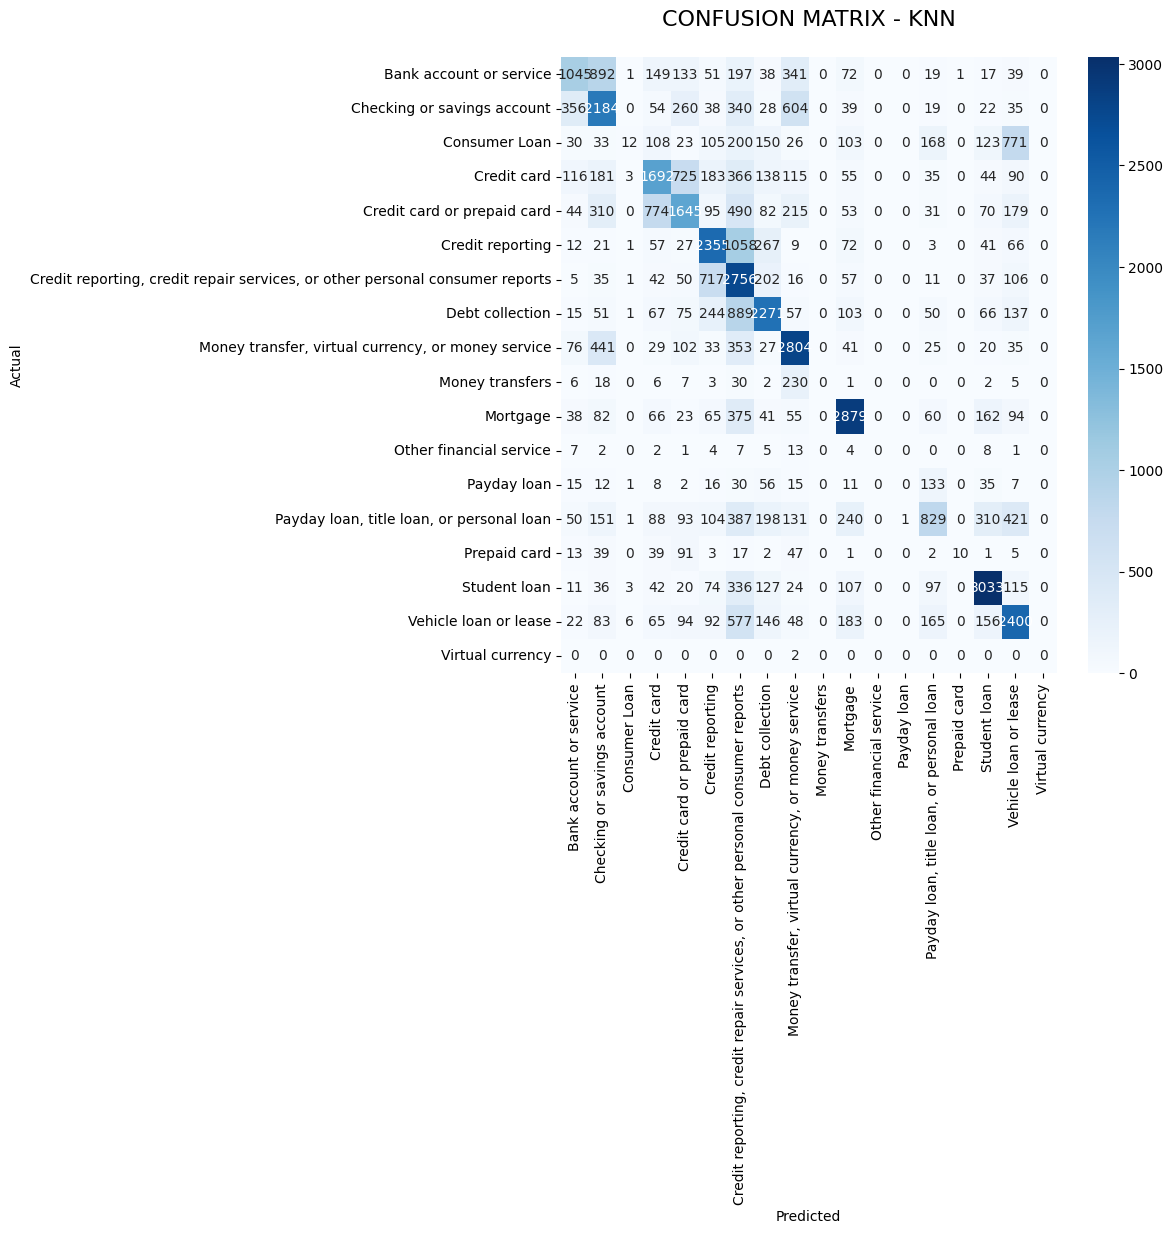

In [ ]:
conf_mat = confusion_matrix(y_test, y_predknn)
fig, ax = plt.subplots(figsize=(8,8))
heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=np.unique(y_test.values), 
            yticklabels=np.unique(y_test.values))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - KNN\n", size=16);


In [ ]:
model = LinearSVC()
model.fit(features, y_train)
y_pred_svc = model.predict(test_features)

In [ ]:
print('CLASSIFICATION METRICS\n')
print(metrics.classification_report(y_test, y_pred_svc,zero_division=0))
print(metrics.accuracy_score(y_test, y_pred_svc))


CLASSIFICATION METRICS

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.60      0.49      0.54      2995
                                                 Checking or savings account       0.57      0.63      0.60      3979
                                                               Consumer Loan       0.51      0.07      0.12      1852
                                                                 Credit card       0.56      0.63      0.60      3743
                                                 Credit card or prepaid card       0.59      0.51      0.55      3988
                                                            Credit reporting       0.64      0.71      0.67      3989
Credit reporting, credit repair services, or other personal consumer reports       0.63      0.61      0.62      4035
                               

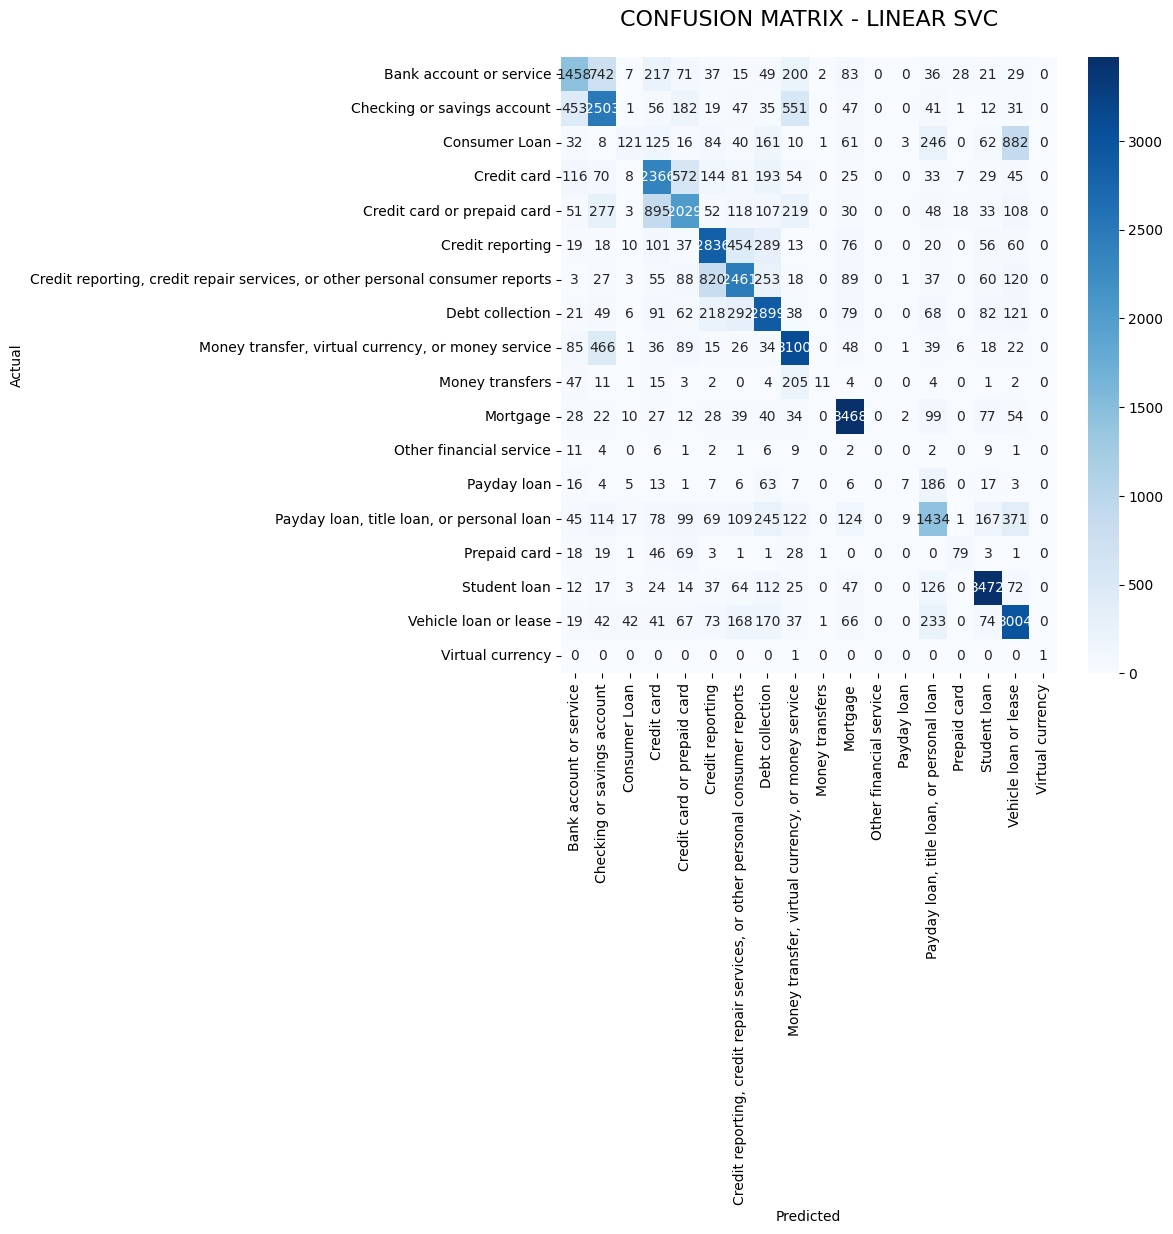

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred_svc)
fig, ax = plt.subplots(figsize=(8,8))
heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=np.unique(y_test.values), 
            yticklabels=np.unique(y_test.values))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LINEAR SVC\n", size=16);


In [ ]:
lr_model = LogisticRegression(max_iter=1000)

lr_model.fit(features, y_train)

y_pred_lr = lr_model.predict(test_features)


In [ ]:
print('CLASSIFICATION METRICS\n')
print(metrics.classification_report(y_test, y_pred_lr,zero_division=0))
print(metrics.accuracy_score(y_test, y_pred_lr))


CLASSIFICATION METRICS

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.60      0.53      0.56      2995
                                                 Checking or savings account       0.59      0.62      0.61      3979
                                                               Consumer Loan       0.45      0.23      0.30      1852
                                                                 Credit card       0.59      0.62      0.60      3743
                                                 Credit card or prepaid card       0.58      0.55      0.57      3988
                                                            Credit reporting       0.65      0.71      0.68      3989
Credit reporting, credit repair services, or other personal consumer reports       0.63      0.63      0.63      4035
                               

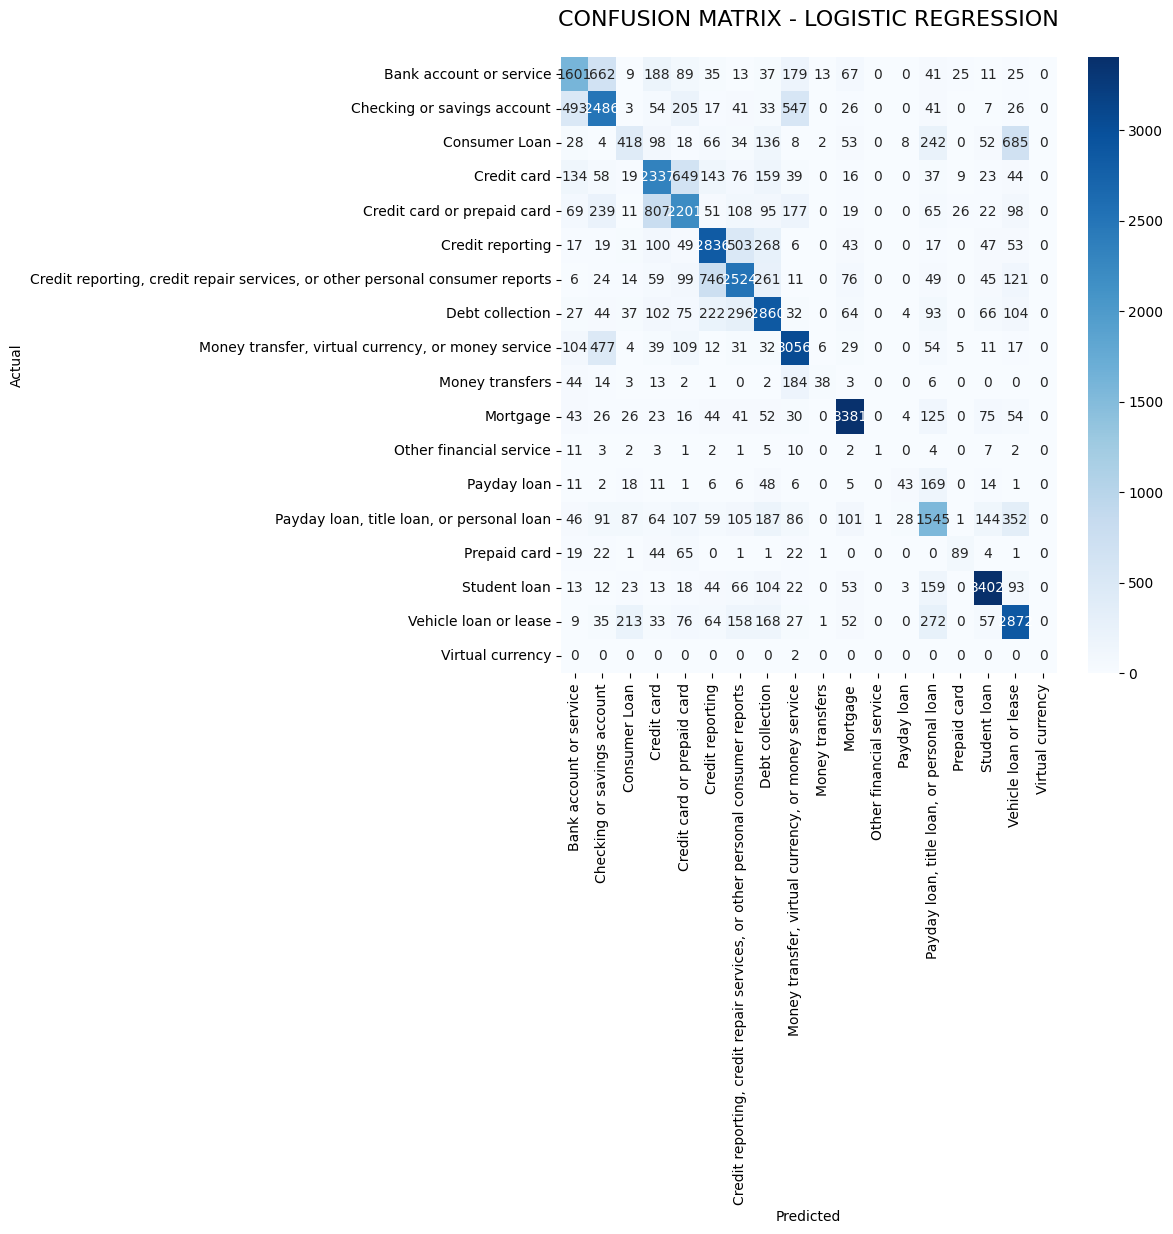

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred_lr)
fig, ax = plt.subplots(figsize=(8,8))
heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=np.unique(y_test.values), 
            yticklabels=np.unique(y_test.values))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LOGISTIC REGRESSION\n", size=16);


In [ ]:
rfc_model = RandomForestClassifier(n_estimators = 100, random_state = 42)

rfc_model.fit(features, y_train)

y_pred_rf = rfc_model.predict(test_features)


In [ ]:
print('CLASSIFICATION METRICS\n')
print(metrics.classification_report(y_test, y_pred_rf,zero_division=0))
print(metrics.accuracy_score(y_test, y_pred_rf))

CLASSIFICATION METRICS

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.64      0.48      0.55      2995
                                                 Checking or savings account       0.56      0.64      0.60      3979
                                                               Consumer Loan       0.58      0.07      0.12      1852
                                                                 Credit card       0.58      0.65      0.61      3743
                                                 Credit card or prepaid card       0.58      0.55      0.56      3988
                                                            Credit reporting       0.67      0.78      0.72      3989
Credit reporting, credit repair services, or other personal consumer reports       0.74      0.62      0.67      4035
                               

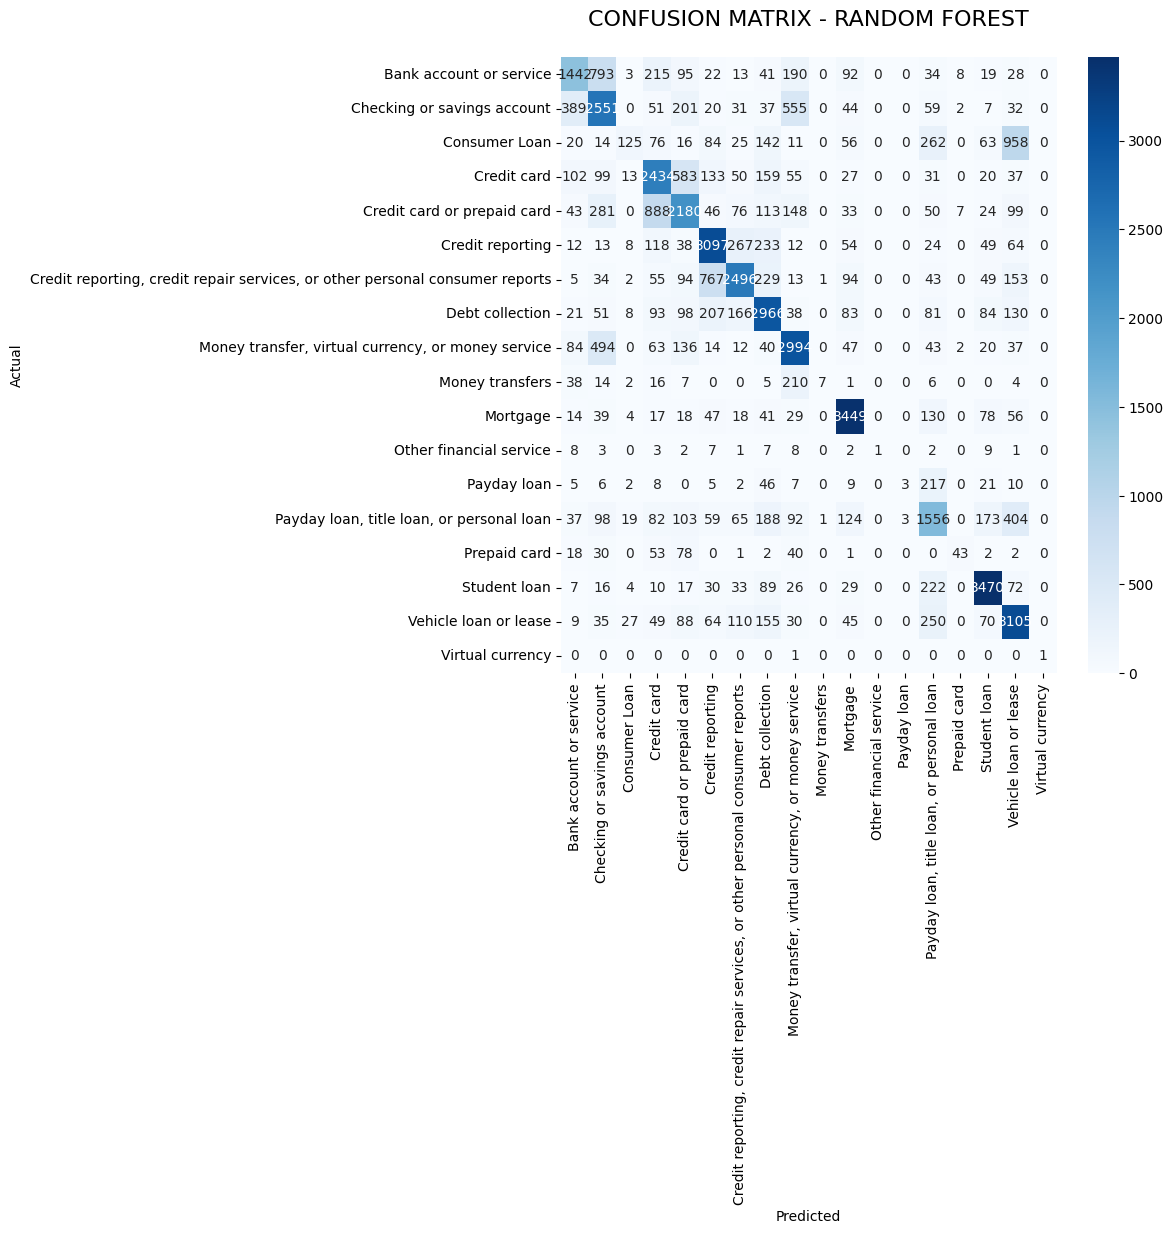

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(figsize=(8,8))
heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=np.unique(y_test.values), 
            yticklabels=np.unique(y_test.values))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - RANDOM FOREST\n", size=16);


In [ ]:
mnb_model = MultinomialNB()
mnb_model.fit(features, y_train)

y_prednb = mnb_model.predict(test_features)

In [ ]:
print('CLASSIFICATION METRICS\n')
print(metrics.classification_report(y_test, y_prednb,zero_division=0))
print(metrics.accuracy_score(y_test, y_prednb))

CLASSIFICATION METRICS

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.62      0.34      0.44      2995
                                                 Checking or savings account       0.49      0.66      0.56      3979
                                                               Consumer Loan       0.65      0.02      0.03      1852
                                                                 Credit card       0.55      0.55      0.55      3743
                                                 Credit card or prepaid card       0.51      0.51      0.51      3988
                                                            Credit reporting       0.60      0.68      0.64      3989
Credit reporting, credit repair services, or other personal consumer reports       0.56      0.62      0.59      4035
                               

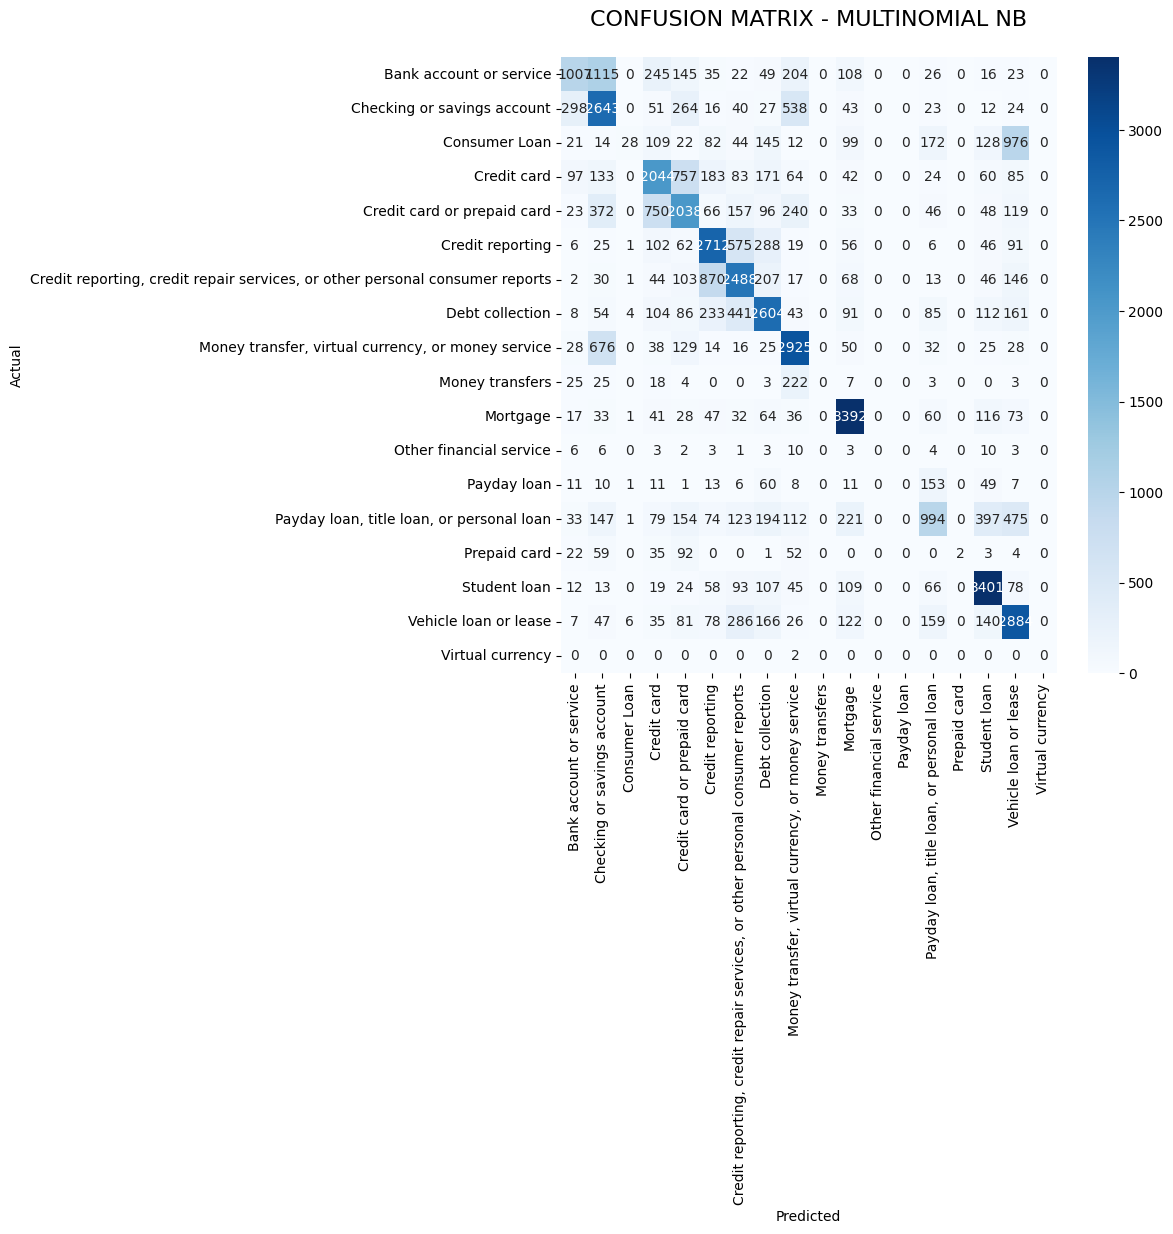

In [ ]:
conf_mat = confusion_matrix(y_test, y_prednb)
fig, ax = plt.subplots(figsize=(8,8))
heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=np.unique(y_test.values), 
            yticklabels=np.unique(y_test.values))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - MULTINOMIAL NB\n", size=16);
